# This exercise was performed on ARCC Beartooth with the following environment/software packages: 

# Load Preinstalled Modules
module load gcc12.2.0 miniconda3 git/2.37.0

# Create environment then activate with:
conda env create -f whatev_ml_env.yml \
conda activate whatev_ml_env

# Make sure jupyter can see the kernel in your conda env so you can select from southpass interface dropdown:
python -m ipykernel install --user --name=whatev_conda_torch 

# Download data to folder and extract
wget https://archive.ics.uci.edu/static/public/186/wine+quality.zip \
unzip wine+quality.zip


In [5]:
#importing all necessary libraries
import os,sys,platform
import numpy as np
import pandas as pd
import tqdm #A progress bar
import matplotlib.pyplot as plt
import torch as torch

#For our ML Model Blueprint
from sklearn import svm, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

#Tools for data processing and model evaluation metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, ValidationCurveDisplay, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse # for Linear Regression 
from sklearn.metrics import accuracy_score as score # for Classification
from sklearn.metrics import confusion_matrix as cm # for Classification
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix # for Classification

In [6]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"PyTorch Version: ", torch.__version__)
print(f"Pandas Version: " , pd.__version__)

Python Platform:Linux-4.18.0-513.11.1.el8_9.x86_64-x86_64-with-glibc2.28
Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
PyTorch Version:  2.1.2
Pandas Version:  2.1.4


In [7]:
#checking devices available

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# Pretty-print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Tesla T4
12.1
Using device:  cuda


# Warmup

Download the [Wine Quality
dataset](https://archive.ics.uci.edu/dataset/186/wine+quality). Choose the
one that corresponds to your preference in wine.

Downloaded and unzipped to folder/repo

In [8]:
#Import data and separate out
data = pd.read_csv('winequality-red.csv',sep=';')

#view data, get info about it, clean if necessary
data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1589,6.6,0.725,0.20,7.8,0.073,29.0,79.0,0.99770,3.29,0.54,9.2,5
1590,6.3,0.550,0.15,1.8,0.077,26.0,35.0,0.99314,3.32,0.82,11.6,6
1591,5.4,0.740,0.09,1.7,0.089,16.0,26.0,0.99402,3.67,0.56,11.6,6
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

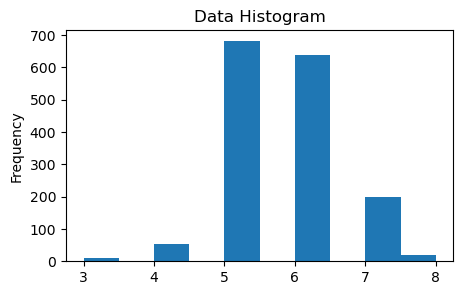

In [9]:
#data looks good, export and pull label data from rest of the dataset
labels = data.pop("quality")
display(labels) #should be a list of int64s

#Show a histogram of the distribution of label data
plot = labels.plot(kind='hist', title="Data Histogram", figsize=(5,3))

## Regression

Build a regression model to predict the wine quality. You can choose any model
type you like; the purpose of this exercise is to get you started. Evaluate the
performance of your trained model -- make sure to get an unbiased performance
estimate!

In [10]:
#Initial Regression Model to Predict Wine Quality Using sklearn linear regression prepackaged ML
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

#AKA'ing our data into X features and y labels
#Uses train_test_split for model evals and use to shuffle our data and randomize what gets parsed to test and train
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, labels, train_size=.75, shuffle=True,random_state=0)

The Linear Regression Model Prediction Score is:  0.3632493675603261
The accuracy for this Linear Regression Model is:  0.400072527085055


<Figure size 640x480 with 0 Axes>

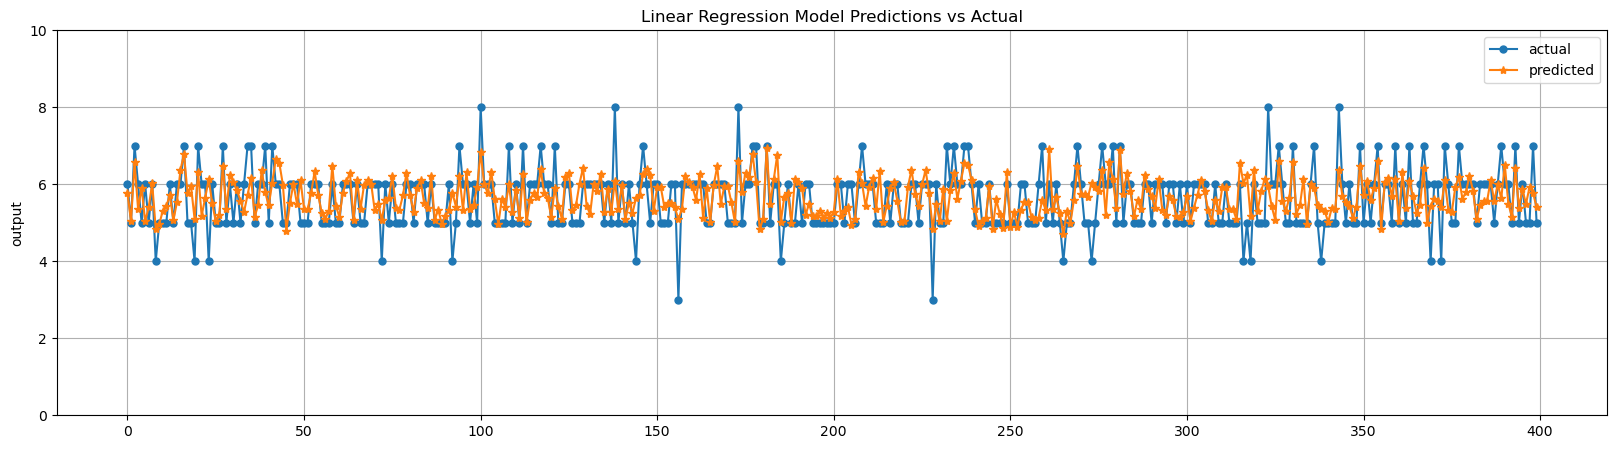

In [11]:
#Make a simple linear regression model called lr and fit it on training data
lr = linear_model.LinearRegression()
lr.fit(X_train_raw, y_train)

lrPredictions = lr.predict(X_test_raw)

lrModelScore = lr.score(X_train_raw, y_train) #Gets coefficient of determination of the prediction - Here that's the R2 Score

#We need to convert our y_actual values to plot them correctly.
y_test_np = y_test.to_numpy()

print("The Linear Regression Model Prediction Score is: ", lrModelScore)

wineLRAccuracy = mse(y_test, lrPredictions)
print("The accuracy for this Linear Regression Model is: ", wineLRAccuracy)

plt.clf()
plt.figure(figsize=(20,5))
plt.title("Linear Regression Model Predictions vs Actual")
plt.plot(y_test_np, label="actual", marker="o", markersize=5)
plt.plot(lrPredictions, label="predicted", marker="*")
plt.ylabel("output")
plt.ylim(0,10)
plt.grid(True)
plt.legend()
plt.show()


## Classification

Now predict the wine quality as a class, i.e. model the problem as a
classification problem. Evaluate the performance of your trained model again.

In [12]:
#Initial Classification Model to Predict Wine Quality Using sklearn linear regression prepackaged ML
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm

#AKA'ing our data into X features and y labels
#Uses train_test_split for model evals and use to shuffle our data and randomize what gets parsed to test and train
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, labels, train_size=.75, shuffle=True,random_state=0)

[6 5 6 5 6 5 5 6 5 5 5 5 6 5 5 6 6 6 6 5 6 5 6 6 5 5 5 6 5 6 6 6 6 5 6 6 5
 5 6 6 5 6 6 6 6 5 5 6 5 6 5 5 6 6 6 5 5 5 6 5 5 6 6 6 5 6 5 6 6 6 5 5 5 5
 5 6 5 5 5 6 6 5 6 6 5 5 6 5 5 5 5 5 6 5 6 5 6 5 5 6 6 6 6 6 6 5 6 5 6 5 6
 5 6 5 6 6 6 6 6 6 5 6 5 5 6 6 5 5 6 6 5 5 6 6 6 5 6 5 6 5 6 5 5 5 6 6 6 6
 6 5 6 6 5 6 6 6 5 5 6 6 6 5 6 5 6 5 6 6 5 6 6 5 5 6 6 6 6 6 6 5 5 6 5 6 6
 5 5 6 5 6 6 6 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 6 5 6 6 5 6 5 5 6 6 6 5 5 6
 6 6 5 6 6 6 5 5 5 6 5 6 6 6 6 6 6 6 5 5 5 5 6 5 5 5 5 6 5 5 5 5 5 5 5 5 5
 6 5 6 5 5 5 5 5 5 6 6 5 6 5 6 6 6 6 5 6 6 5 6 6 6 6 5 5 5 6 6 6 6 6 5 5 6
 5 5 5 5 6 5 5 5 6 6 5 5 5 5 6 6 5 5 5 6 6 6 5 6 5 6 6 6 5 5 6 5 5 5 6 5 5
 6 5 6 6 5 5 5 5 5 5 6 6 5 5 5 5 6 6 6 5 6 6 5 6 6 6 6 5 6 5 6 6 5 5 6 5 5
 6 6 5 6 5 5 6 6 6 6 6 6 5 5 5 6 6 5 6 5 6 5 5 6 5 6 5 6 6 5]
[6 5 7 6 5 6 5 6 4 5 5 5 6 5 6 6 7 5 5 4 7 6 6 4 6 5 5 7 5 6 5 6 5 6 7 7 5
 6 6 7 5 7 6 6 5 5 6 6 6 5 5 5 6 6 6 5 5 5 6 5 5 6 6 6 5 6 5 5 6 6 6 6 4 6
 5 6 5 5 5 6 6 5 6 6 6 5 6 5 5 5 5 6 4

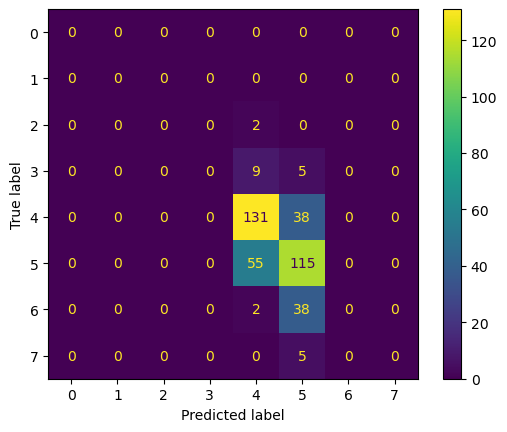

In [16]:
#Create a classification model named classify
classify = svm.SVC(kernel="linear", gamma='auto', C=5)
classify.fit(X_train_raw, y_train)
classPredictions = classify.predict(X_test_raw)

classModelScore = classify.score(X_train_raw, y_train) #Return the mean accuracy on the given test data and labels.

print(classPredictions)
flat_y = y_test.to_numpy() #flattened version (1D List of y_test labels)
print(flat_y)
print("The classification score for this Classification Model is: ", classModelScore)

wineClassAccuracy = score(y_test, classPredictions)  #Accuracy score for classification
print("The accuracy for this Classification Model is: ", wineClassAccuracy)


wineClassConfMatrix = cm(y_test, classPredictions, labels=[1,2,3,4,5,6,7,8])
disp=showMatrix(wineClassConfMatrix)
disp.plot()
plt.show()

## Submission

Upload your code and a brief description of your results.